## Setup

In [1]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom/neuralwarp/pyLDDMM"))

print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())



%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom/neuralwarp/pyLDDMM
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom/neuralwarp
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom/neuralwarp/pyLDDMM


## Imports

In [2]:
import pyLDDMM
from pyLDDMM.utils.visualization import loadimg, saveimg, save_animation, plot_warpgrid
import matplotlib.pyplot as plt

In [3]:
i0 = loadimg('./example_images/circle.png')
i1 = loadimg('./example_images/square.png')

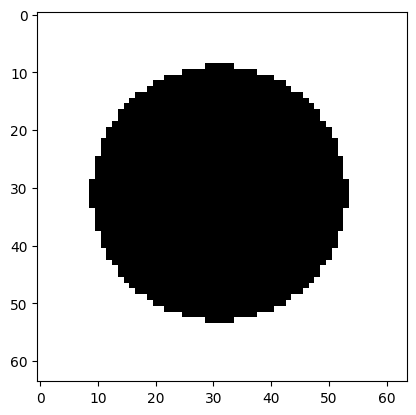

In [4]:
plt.imshow(i0, cmap ="gray")

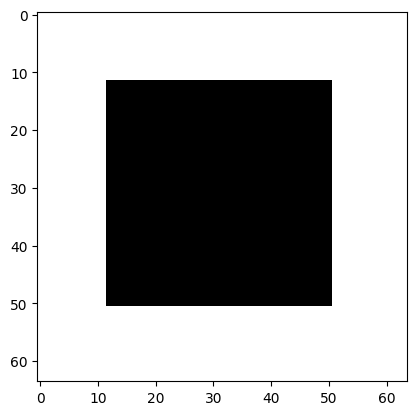

In [5]:
plt.imshow(i1, cmap="gray")

In [6]:
lddmm = pyLDDMM.LDDMM2D()
im, v, energies, length, Phi0, Phi1, J0, J1 = lddmm.register(i0, i1, sigma=0.1, alpha=1, epsilon=0.0001, K=20)

iteration   0, energy 27600.00, thereof 0.00 regularization and 27600.00 intensity difference
iteration   1, energy 17869.66, thereof 14.18 regularization and 17855.48 intensity difference
iteration   2, energy 14373.11, thereof 25.32 regularization and 14347.79 intensity difference
iteration   3, energy 10925.47, thereof 34.76 regularization and 10890.70 intensity difference
iteration   4, energy 7799.57, thereof 42.63 regularization and 7756.94 intensity difference
iteration   5, energy 6204.14, thereof 48.87 regularization and 6155.27 intensity difference
iteration   6, energy 4883.10, thereof 53.78 regularization and 4829.31 intensity difference
iteration   7, energy 3817.61, thereof 57.64 regularization and 3759.97 intensity difference
iteration   8, energy 3272.58, thereof 60.69 regularization and 3211.89 intensity difference
iteration   9, energy 3001.64, thereof 63.15 regularization and 2938.49 intensity difference
iteration  10, energy 2521.47, thereof 65.11 regularization and

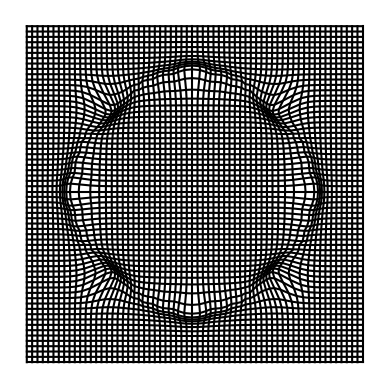

In [13]:
plot = plot_warpgrid(Phi0[-1], interval=1)

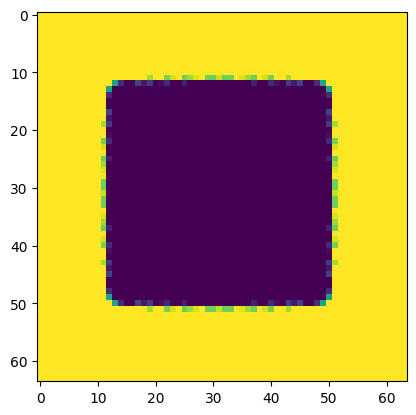

In [29]:
plt.imshow(J0[-1])

In [36]:
Phi1[0].shape

(64, 64, 2)

In [35]:
i0.shape

(64, 64)

In [45]:
Phi0[0].shape

(64, 64, 2)

In [47]:
x = Phi0[0]

y = Phi0[-1]


input_data = x.reshape((-1, 2))
output_data = y.reshape((-1, 2))

In [50]:
input_data[1]

array([1., 0.])

In [51]:
output_data[1]

array([1.00000037e+00, 2.57492506e-07])

In [ ]:
# write a fullly connected neural network with n_layers hidden layers
# each layer has n_neurons neurons
class FCNET(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FCNET, self).__init__()
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.layers = torch.nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(torch.nn.Linear(n_neurons, n_neurons))
        self.out = torch.nn.Linear(n_neurons, 1)

    def forward(self, x):
        for i in range(self.n_layers):
            x = self.layers[i](x)
        x = self.out(x)
        return x
    
# train the neural network on the data input_data


In [ ]:
# train the neural network on the data input_data with Adam optimizer
def train(net, input_data, output_data, n_epochs, batch_size, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for epoch in range(n_epochs):
        for i in range(0, input_data.shape[0], batch_size):
            x = input_data[i:i+batch_size]
            y = output_data[i:i+batch_size]
            optimizer.zero_grad()
            y_pred = net(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print('Epoch %d, loss %.4f' % (epoch, loss.item()))

In [236]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def create_gaussian_image(width, height, resolution, x_variance, y_variance, distance):
    x = np.linspace(0, width-1, int(width/resolution))
    y = np.linspace(0, height-1, int(height/resolution))
    x, y = np.meshgrid(x, y)
    

    pos = np.dstack((x, y))

    mu1 = np.array([width/2-distance/2, height/2]) 
    cov1 = np.array([[x_variance, 0], [0, y_variance]])  # covariance matrix

    rv1 = multivariate_normal(mu1, cov1)
    
    mu2 = np.array([width/2+distance/2, height/2]) 
    cov2 = np.array([[x_variance, 0], [0, y_variance]])  # covariance matrix

    rv2 = multivariate_normal(mu2, cov2)
    
    
    
    intensity_values1 = rv1.pdf(pos)
    intensity_values2 = rv2.pdf(pos)
    intensity_values = intensity_values1 + intensity_values2
    intensity_values = intensity_values/np.sum(intensity_values)

    return intensity_values

def create_uniform_image(width, height, resolution):
    x = np.linspace(-1, 1, int(width/resolution))
    y = np.linspace(-1, 1, int(height/resolution))
    x, y = np.meshgrid(x, y)


    # Calculate intensity values based on distance from center
    intensity_values = np.ones_like(x)
    
    intensity_values = intensity_values/np.sum(intensity_values)

    return intensity_values

In [263]:
image1 = create_gaussian_image(width=10,height=10,resolution=0.2,x_variance=0.2,y_variance=0.4, distance=4)

image2 = create_gaussian_image(width=10,height=10,resolution=0.2,x_variance=1,y_variance=0.4, distance=4)
#image2 = create_uniform_image(width=5,height=5,resolution=0.1)

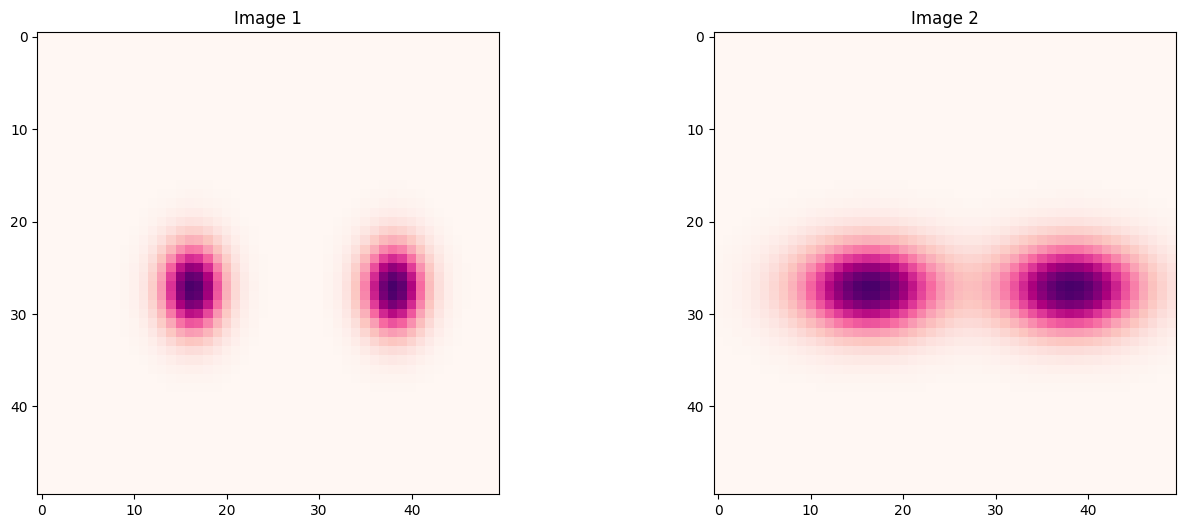

In [264]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first image on the first subplot
axs[0].imshow(image1, cmap='RdPu')
axs[0].set_title('Image 1')

# Plot the second image on the second subplot
axs[1].imshow(image2, cmap='RdPu')
axs[1].set_title('Image 2')

# Display the plots
plt.show()

In [265]:
lddmm = pyLDDMM.LDDMM2D()
im, v, energies, length, Phi0, Phi1, J0, J1 = lddmm.register(image1, image2, sigma=0.1, alpha=1, epsilon=0.0001, K=100)

iteration   0, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   1, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   2, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   3, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   4, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   5, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   6, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   7, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   8, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration   9, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration  10, energy 0.14, thereof 0.00 regularization and 0.14 intensity difference
iteration  11, energy 0.14, thereof 0.00 regularizatio

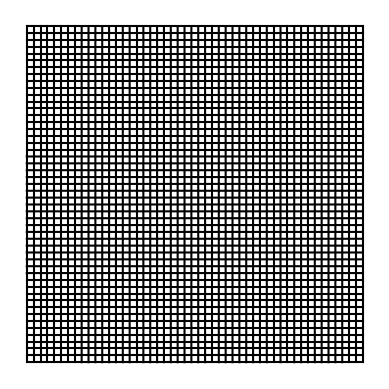

In [258]:
plot = plot_warpgrid(Phi0[-1], interval=1)